In [29]:
import math
import matplotlib.pyplot as plt
import numpy as np
import mnist_reader
import tensorflow as tf
from tensorflow.python.framework import ops
from matplotlib.pyplot import imread

In [30]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    return X, Y

In [31]:
def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = tf.get_variable('W' + str(l), [layer_dims[l], layer_dims[l-1]], initializer = tf.contrib.layers.xavier_initializer())
        parameters['b' + str(l)] = tf.get_variable('b' + str(l), [layer_dims[l], 1], initializer = tf.zeros_initializer())
    return parameters

In [32]:
def one_hot_conversion(labels, C): # The labels come in as a rank 1 array.
    classes_tensor = tf.constant(C, name='C')
    one_hot_tensor = tf.one_hot(labels, C, axis = 0)
    with tf.Session() as sess:
        one_hot_matrix = sess.run(one_hot_tensor)
    return one_hot_matrix

In [33]:
def relu_forward(A_prev, W, b):
    Z = tf.add(tf.matmul(W, A_prev), b)
    A = tf.nn.relu(Z)
    return A

In [34]:
def forward_propagation(X, parameters):
    A = X
    L = len(parameters) // 2
    
    # All relu layers
    for l in range(1, L):
        A_prev = A
        A = relu_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)])
        
    # Last layer logits
    ZL = tf.add(tf.matmul(parameters['W' + str(L)], A), parameters['b' + str(L)])
    return ZL

In [35]:
def compute_cost(ZL, Y, parameters, lambd, L2_Regularization = False):
    if L2_Regularization == False:
        logits = tf.transpose(ZL)
        labels = tf.transpose(Y)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    else:
        L = len(parameters) // 2
        regularizer = 0
        for l in range (1, L):
            regularizer += tf.nn.l2_loss(parameters['W' + str(l)])
        logits = tf.transpose(ZL)
        labels = tf.transpose(Y)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
        cost = tf.reduce_mean(cost + lambd * regularizer)
    return cost

In [36]:
def random_mini_batches(X, Y, mini_batch_size):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [37]:
X_train, Y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, Y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_train = X_train.T
X_test = X_test.T

In [45]:
def model(X_train, Y_train, X_test, Y_test, lambd,
          learning_rate = 0.0001, num_epochs = 1000, minibatch_size = 500, 
          print_cost = False, L2_Regularization = True):
    
    ops.reset_default_graph()
    (n_x, m) = X_train.shape
    C = len(np.unique(Y_train))
    n_y = C
    Y_train = one_hot_conversion(Y_train, C)
    Y_test = one_hot_conversion(Y_test, C)
    layer_dims = [n_x, 32, 32, 32, n_y]  # Change the values between n_x and n_y to expand or contract the Neural Network.
    costs = []
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters(layer_dims)
    ZL = forward_propagation(X, parameters)
    cost = compute_cost(ZL, Y, parameters, lambd, L2_Regularization)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch {}: {}".format(epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                plt.plot(np.squeeze(costs))
            if print_cost == True:
                plt.ylabel('cost')
                plt.xlabel('iterations (per tens)')
                plt.title("Learning rate =" + str(learning_rate))
                plt.show()
        
        parameters = sess.run(parameters)
        print('Parameters have been trained!')
        
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
        print ("lambd:" + str(lambd))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

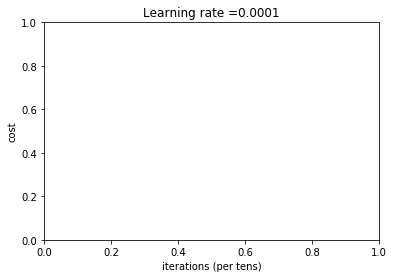

Parameters have been trained!
lambd:0.01
Train Accuracy: 0.97675
Test Accuracy: 0.8658


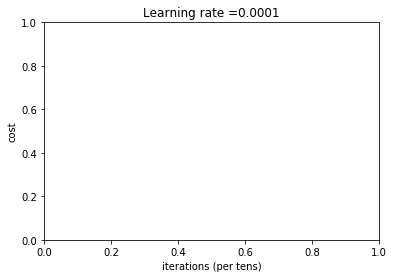

Parameters have been trained!
lambd:0.03
Train Accuracy: 0.9668667
Test Accuracy: 0.8701


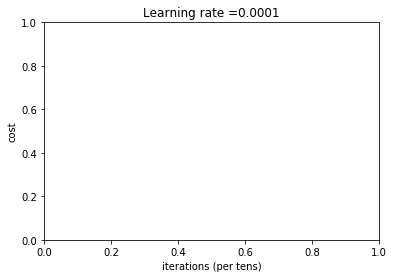

Parameters have been trained!
lambd:0.09
Train Accuracy: 0.93348336
Test Accuracy: 0.8703


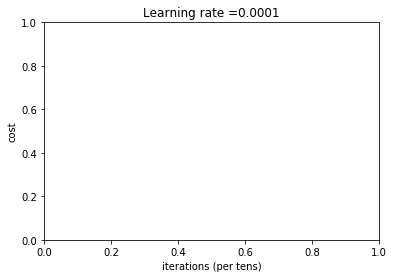

Parameters have been trained!
lambd:0.3
Train Accuracy: 0.90005
Test Accuracy: 0.8642


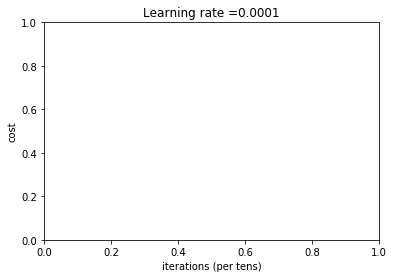

Parameters have been trained!
lambd:0.9
Train Accuracy: 0.87935
Test Accuracy: 0.8573


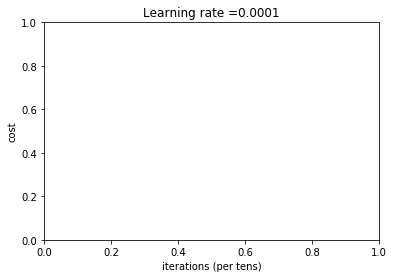

Parameters have been trained!
lambd:3
Train Accuracy: 0.8247333
Test Accuracy: 0.8112


In [44]:
lambds = [.01, .03, .09, .3, .9, 3]
lambd_parameters = {}
for lambd in lambds:
    parameters = model(X_train, Y_train, X_test, Y_test, lambd = lambd)
    lambd_parameters[lambd] = parameters

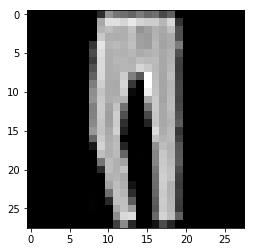

In [46]:
index = 24500
image = X_train[:,index]
image = image.reshape((28,28))
plt.imshow(image, cmap='gray')

In [49]:
lambd_parameters[.09]

{'W1': array([[-4.5119321e-34, -9.3788580e-34, -1.1514125e-33, ...,
          9.3760148e-34, -1.1729141e-33, -2.8585598e-34],
        [-9.9641702e-06, -1.2713982e-04,  4.0076871e-04, ...,
         -4.1937637e-03, -6.8096655e-05, -4.2544850e-04],
        [-2.5385292e-05, -4.4544731e-04, -2.9728273e-03, ...,
         -1.5464580e-03,  2.5343692e-03, -2.9476115e-04],
        ...,
        [-2.1031663e-15, -1.6915292e-04, -1.7796252e-03, ...,
          3.1934108e-03,  5.3190845e-03, -8.3539914e-04],
        [-4.0924510e-06, -2.8852235e-05,  2.5520538e-04, ...,
         -3.5551358e-03, -2.7684299e-03, -6.0346909e-04],
        [-1.1352139e-05,  1.0499813e-04, -3.3878136e-04, ...,
         -1.2403500e-03, -3.7222308e-06, -5.8940986e-07]], dtype=float32),
 'b1': array([[-0.01244614],
        [ 0.2105358 ],
        [ 0.5893495 ],
        [ 0.28426096],
        [ 0.42163497],
        [ 0.5666517 ],
        [ 1.4061561 ],
        [-0.05322925],
        [ 0.28668004],
        [ 0.1984047 ],
        